# Data preparation for StorSeismic pre-training

This notebook contains data preparation for pre-training of StorSeismic (Harsuko and Alkhalifah, 2022). The goal here is to produce a dataset containing input seismic data which are masked trace-wise with their corresponding unmasked data as the output.

## Load required modules

In [1]:
import torch
from snist.dataset import SNIST
import os
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np

import storseismic.utils as utils

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Load data

### Load/download data from SNIST

https://github.com/LukasMosser/SNIST

In [2]:
snist_train = SNIST('./', train=True, download=True) # Training data
snist_test = SNIST('./', train=False, download=True, noise=0) # Testing data

### Create data dictionary

We create four instances in the dictionary:
- <code>inputs_embeds</code> for the input
- <code>labels</code> for the label
- <code>mask_label</code> to mark the masked indices (will useful later in in the pre-training)
- <code>index</code> to store the original, unaugmented indices of the data

In [3]:
snist_train_mlm, snist_test_mlm = {}, {}
for data, data_mlm in zip([snist_train, snist_test], 
                [snist_train_mlm, snist_test_mlm]):
    data_mlm['inputs_embeds'] = data.train_data.detach().clone()
    data_mlm['labels'] =  data.train_data.detach().clone()
    data_mlm['mask_label'] = torch.zeros_like(data.train_data)
    data_mlm['index'] = torch.arange(data.train_data.shape[0])

/home/masa/miniconda3/envs/storseismic/lib/python3.13/site-packages/snist/dataset.py:67: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
# Some cleanup (swap time and offset axis, and remove extra axis)

for data in snist_train_mlm, snist_test_mlm:
    for key in data.keys():
        if key != 'index':
            data[key] = data[key].swapaxes(2, 3)
            data[key] = data[key].squeeze()
            
print("Training data shape: ", snist_train_mlm['inputs_embeds'].shape)
print("Testing data shape: ", snist_test_mlm['inputs_embeds'].shape)

Training data shape:  torch.Size([600, 20, 271])
Testing data shape:  torch.Size([150, 20, 271])


## Pre-processing and augmentation

### Scale the data into the range [-1, 1]

In [5]:
vmin_all = torch.min(snist_train_mlm['inputs_embeds'])
vmax_all = torch.max(snist_train_mlm['inputs_embeds'])

for data_mlm in [snist_train_mlm, snist_test_mlm]:
    data_mlm['inputs_embeds'] = -1 + (2 * (data_mlm['inputs_embeds'] - vmin_all) / (vmax_all - vmin_all))
    data_mlm['labels'] = -1 + (2 * (data_mlm['labels'] - vmin_all) / (vmax_all - vmin_all))
    
vmin_all = -1
vmax_all = 1

### Multiply the data N-times

So that all the masking will be applied N-times (differently) to the data.

In [6]:
mult_factor = 10

for key in snist_train_mlm.keys():
    snist_train_mlm[key] = snist_train_mlm[key].repeat(mult_factor, 1, 1)
snist_train_mlm['index'] = torch.arange(snist_train_mlm['inputs_embeds'].shape[0])
    
for key in snist_test_mlm.keys():
    snist_test_mlm[key] = snist_test_mlm[key].repeat(mult_factor, 1, 1)
snist_test_mlm['index'] = torch.arange(snist_test_mlm['inputs_embeds'].shape[0])

### Apply shifts in time

Time shifting augmentation: We shift each shot gather upward/downward in time randomly within the defined shifting range.

In [7]:
n_shift = 2 # Number of shifts performed for each sample (+ we keep the original, unshifted data)
min_shift_mag = -25 # Max shift upward in time sample
max_shift_mag = 25 # Max shift downward in time sample

filler = torch.mean(snist_train_mlm['inputs_embeds'])
for data in snist_train_mlm, snist_test_mlm:
    data_len = data['inputs_embeds'].shape[0]
    for n in range(n_shift):
        data2 = {key: value[:data_len] for key, value in data.items()}
        for i in range(data_len):
            while True:
                shift_mag = int(torch.randint(low=min_shift_mag-1, high=max_shift_mag+1, size=(1, )))
                if shift_mag != 0:
                    break
            data2['inputs_embeds'][i] = torch.roll(data2['inputs_embeds'][i], shift_mag, -1)
            data2['labels'][i] = torch.roll(data2['labels'][i], shift_mag, -1)
            if shift_mag > 0:
                data2['inputs_embeds'][i, :, :shift_mag] = filler
                data2['labels'][i, :, :shift_mag] = filler
            elif shift_mag < 0:
                data2['inputs_embeds'][i, :, data2['inputs_embeds'].shape[-1]+shift_mag:] = filler
                data2['labels'][i, :, data2['inputs_embeds'].shape[-1]+shift_mag:] = filler

        for key in data.keys():
            data[key] = torch.cat((data[key], data2[key]), 0)

### Mask the data 

Here we mask the shot gather trace-wise. Following Devlin et al. (2018), we use a mask proportion of 15% for each shot gather (3 out of 20 traces) with the details of the following:
- 80% of the time we mask with a [mask] token (i.e., random numbers drawn from Gaussian distribution)
- 10% of the time we replace with another trace from the same shot gather
- 10% of the time we keep the trace as is

In [8]:
seed = 123
torch.manual_seed(seed)
mask_token = torch.randn(1, 1, snist_train_mlm['inputs_embeds'].shape[-1]) # The [mask] token
mask_token = -1 + (2 * (mask_token - torch.min(mask_token)) / (torch.max(mask_token) - torch.min(mask_token))) # Scale the [mask] token to [-1, 1]

def mask_all(data, mask_proportion=.15):
    seq_len = data['inputs_embeds'].shape[1]
    for i in range(data['inputs_embeds'].shape[0]):
        muted_idx = torch.randperm(seq_len)[:int(np.floor(seq_len * mask_proportion))]
        for j in muted_idx:
            prob = torch.rand(1)
            if prob < 0.8:
                data['inputs_embeds'][i, j, :] = mask_token
            elif prob >= 0.8 and prob < 0.9:
                switch_idx = torch.where(torch.arange(seq_len) != j)[0][torch.randint(high=seq_len-1, size=(1,))]
                data['inputs_embeds'][i, j, :] = data['inputs_embeds'][i, switch_idx, :].squeeze(-1)
            else:
                data['inputs_embeds'][i, j, :] = data['inputs_embeds'][i, j, :]

        data['mask_label'][i, muted_idx] = 1
            
    return data

for data_mlm in snist_train_mlm, snist_test_mlm:
    data_mlm = mask_all(data_mlm, mask_proportion=.15)

### Apply polarity reversal

Polarity reversal augmentation: We reverse the polarity of the data, as if we use a reversed polarity of the source. This is done simply by multiplying the data by -1.

In [9]:
polarity_change = True

if polarity_change:
    for data in snist_train_mlm, snist_test_mlm:
        augmented = data.copy()
        augmented['inputs_embeds'] = augmented['inputs_embeds'] * -1
        augmented['labels'] = augmented['labels'] * -1
        for key in augmented.keys():
            data[key] = torch.cat((data[key], augmented[key]), 0)

## Finalize

### Wrap in a custom Pytorch dataset

In [10]:
train_data = utils.SSDataset(snist_train_mlm)
test_data = utils.SSDataset(snist_test_mlm)

### Visualize created dataset

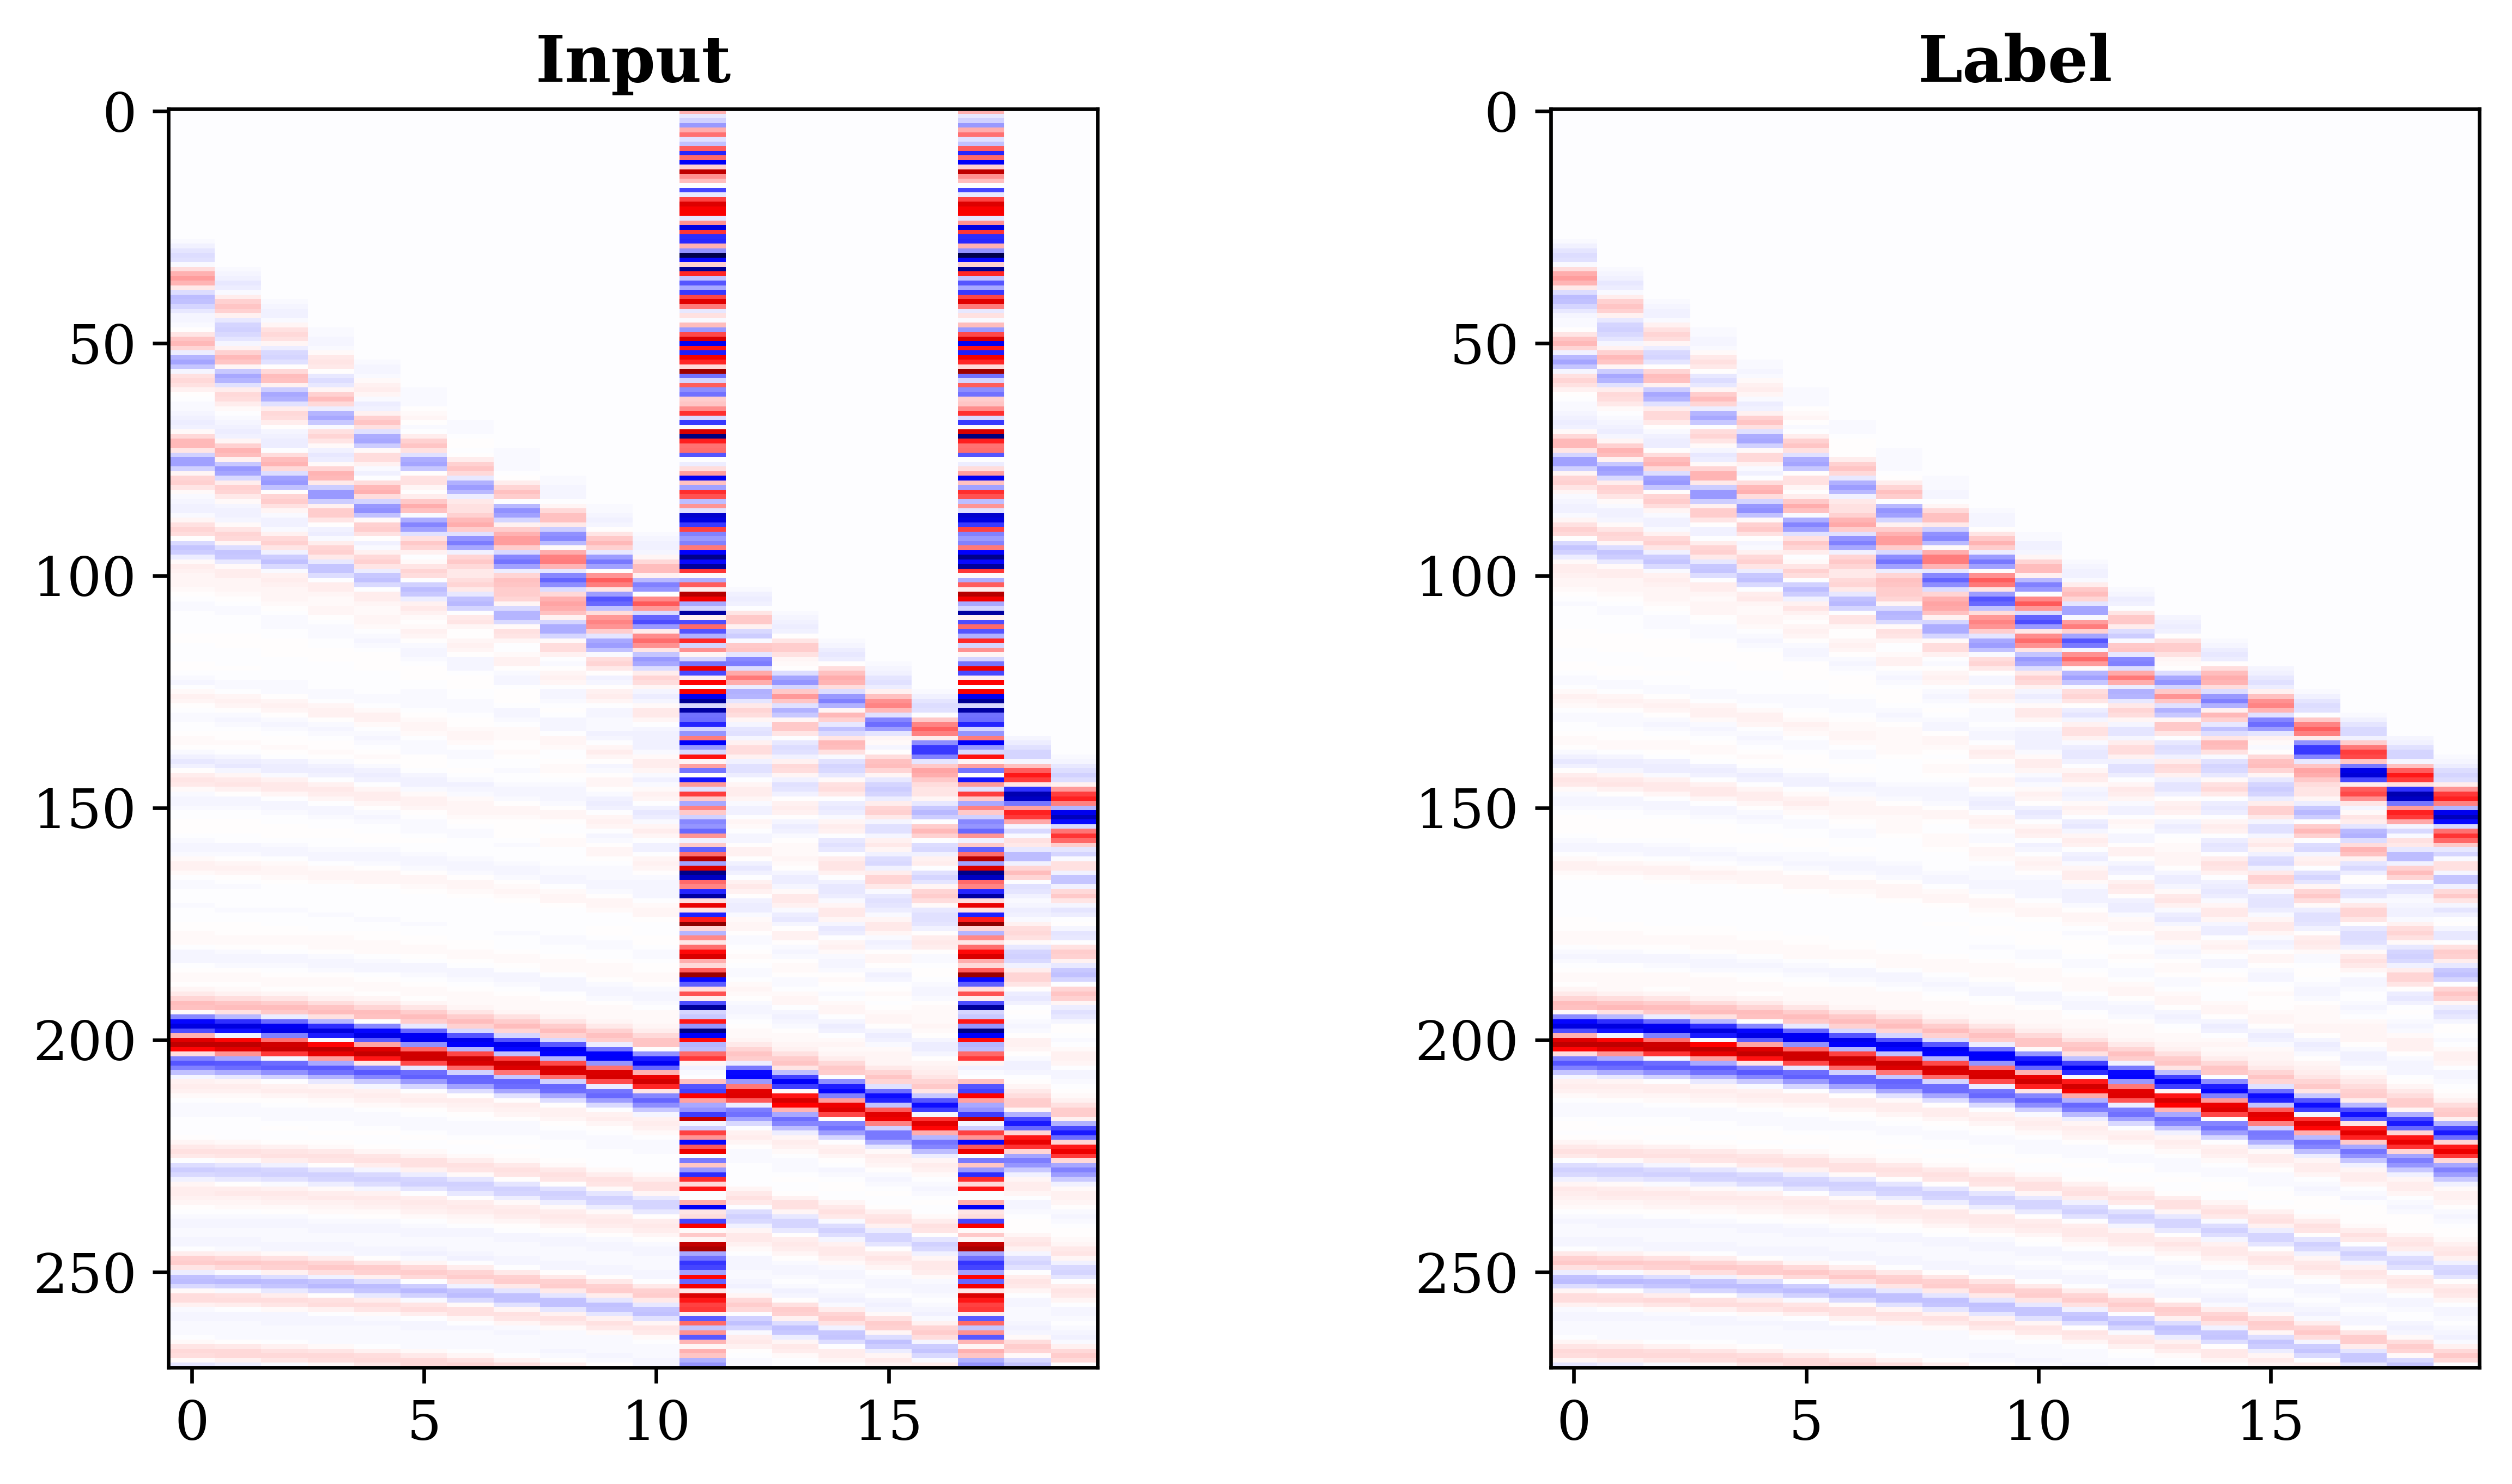

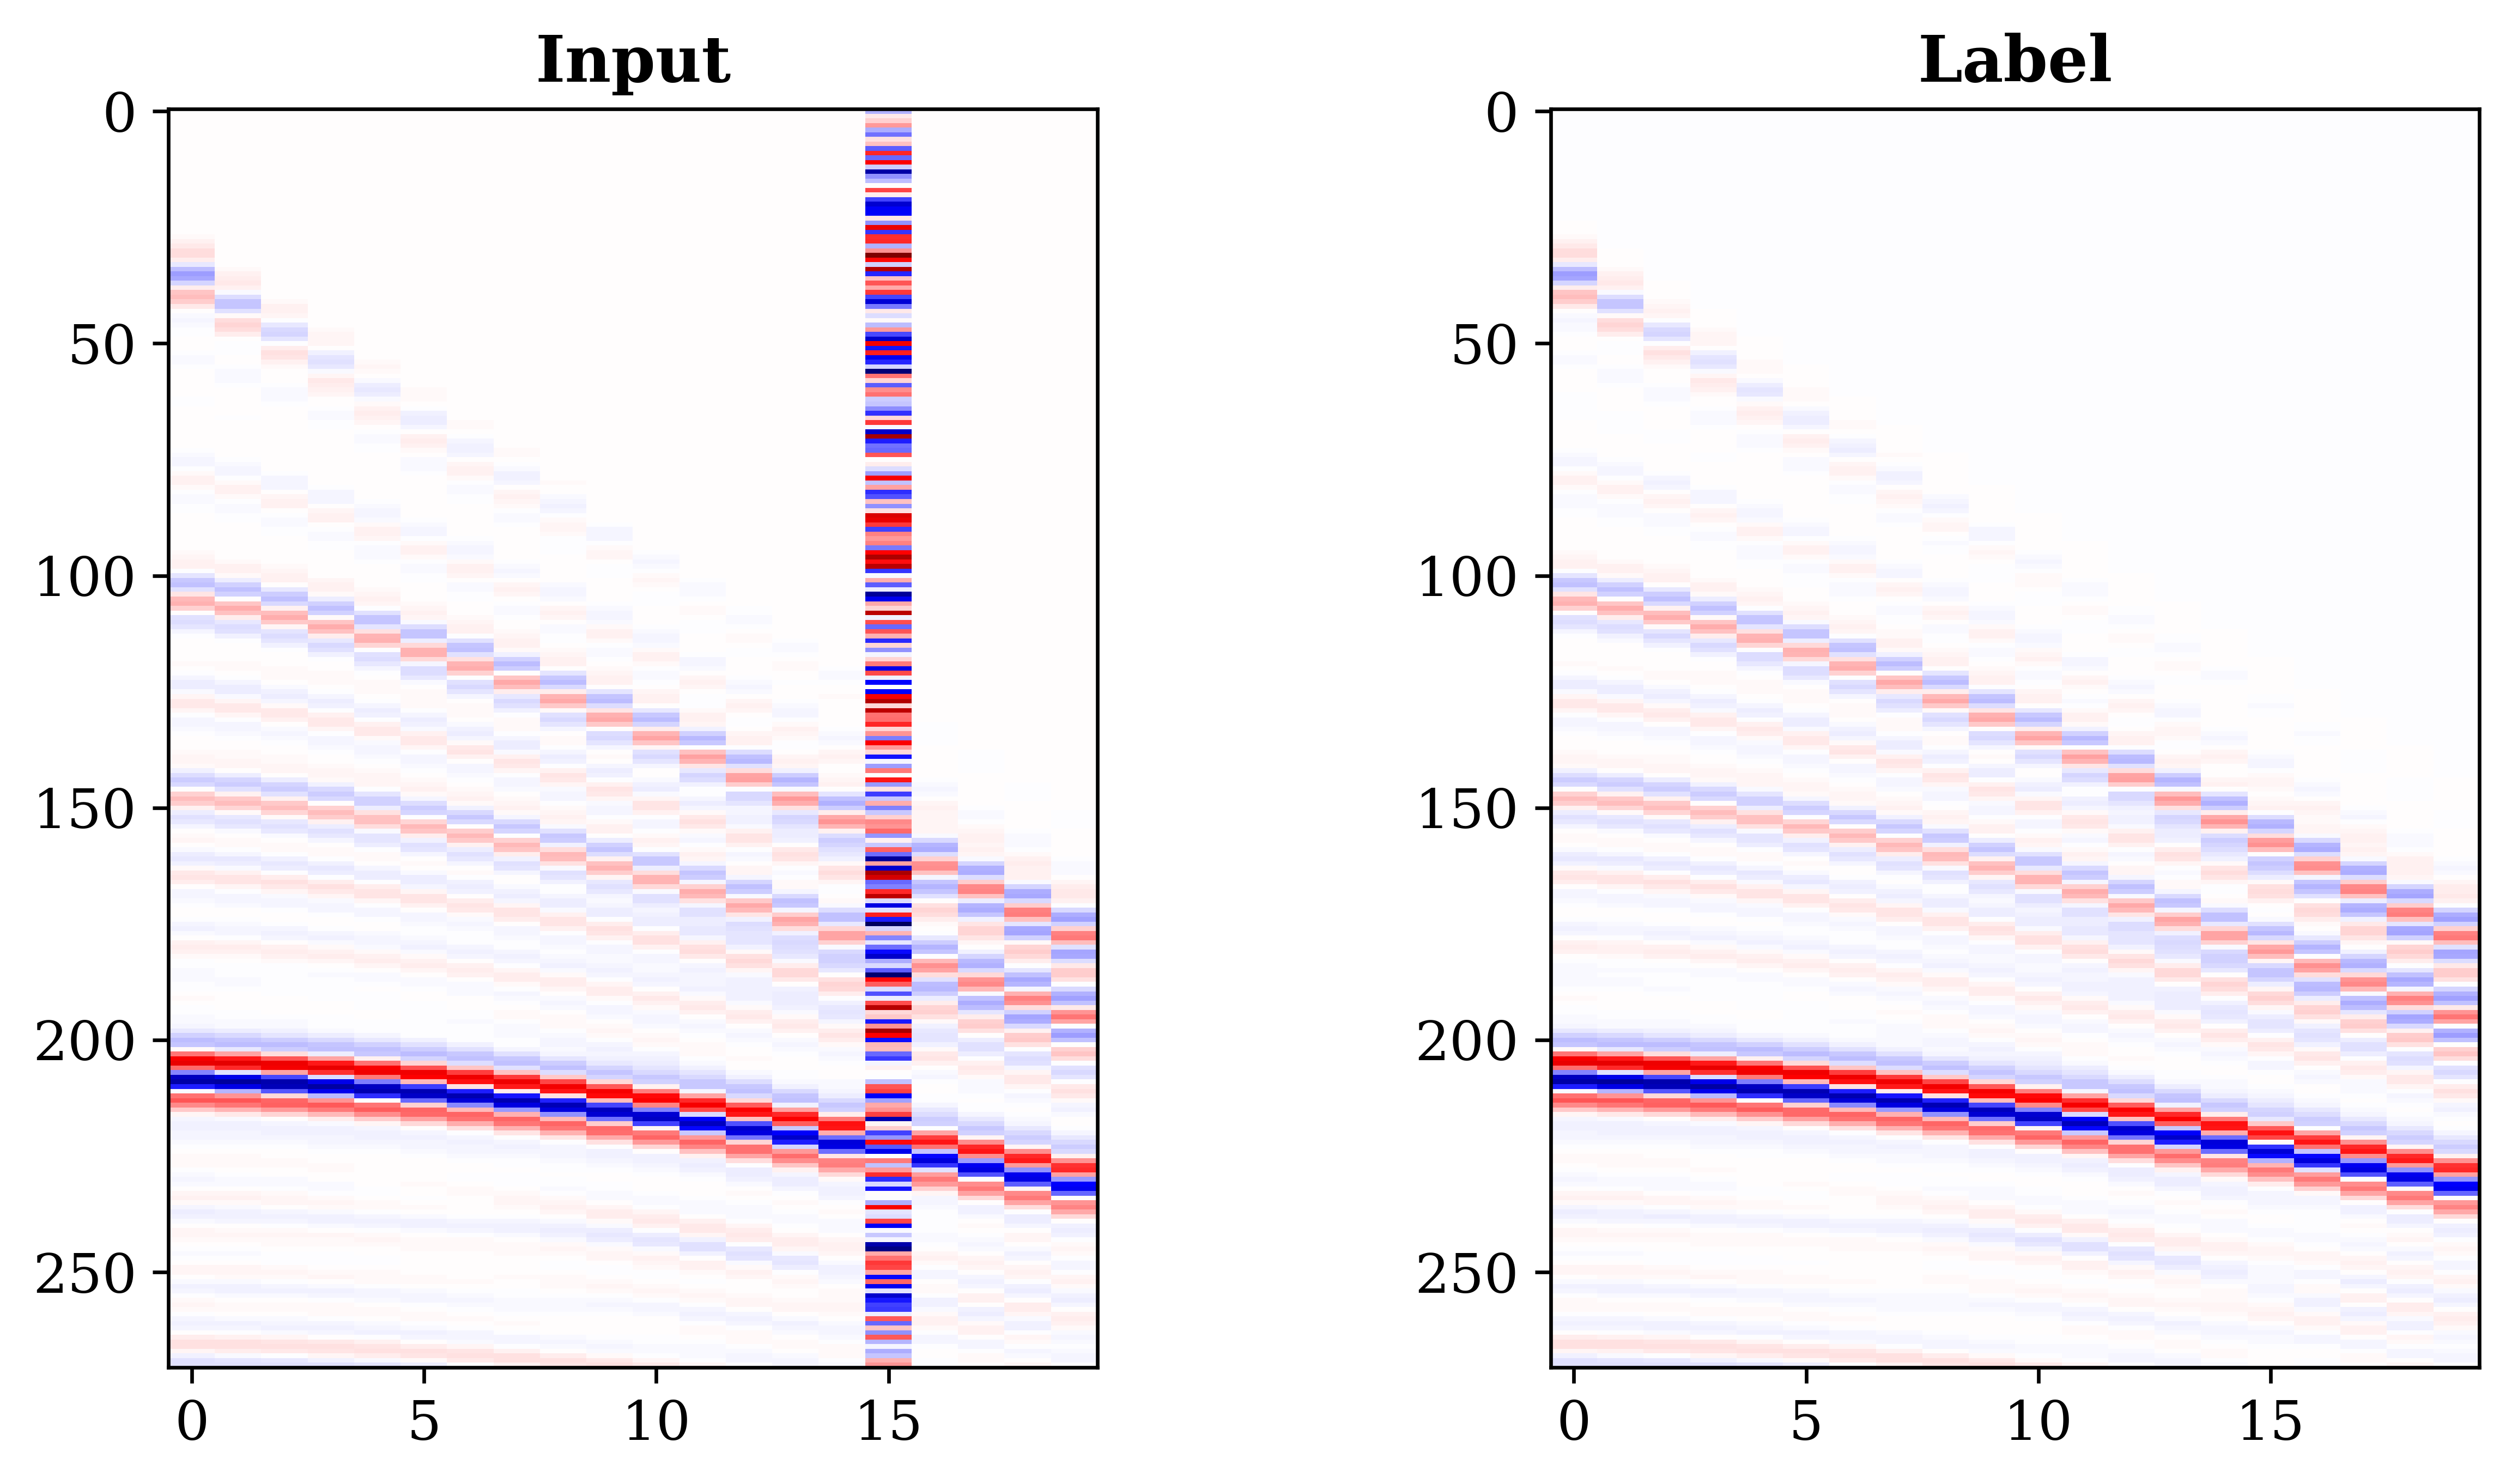

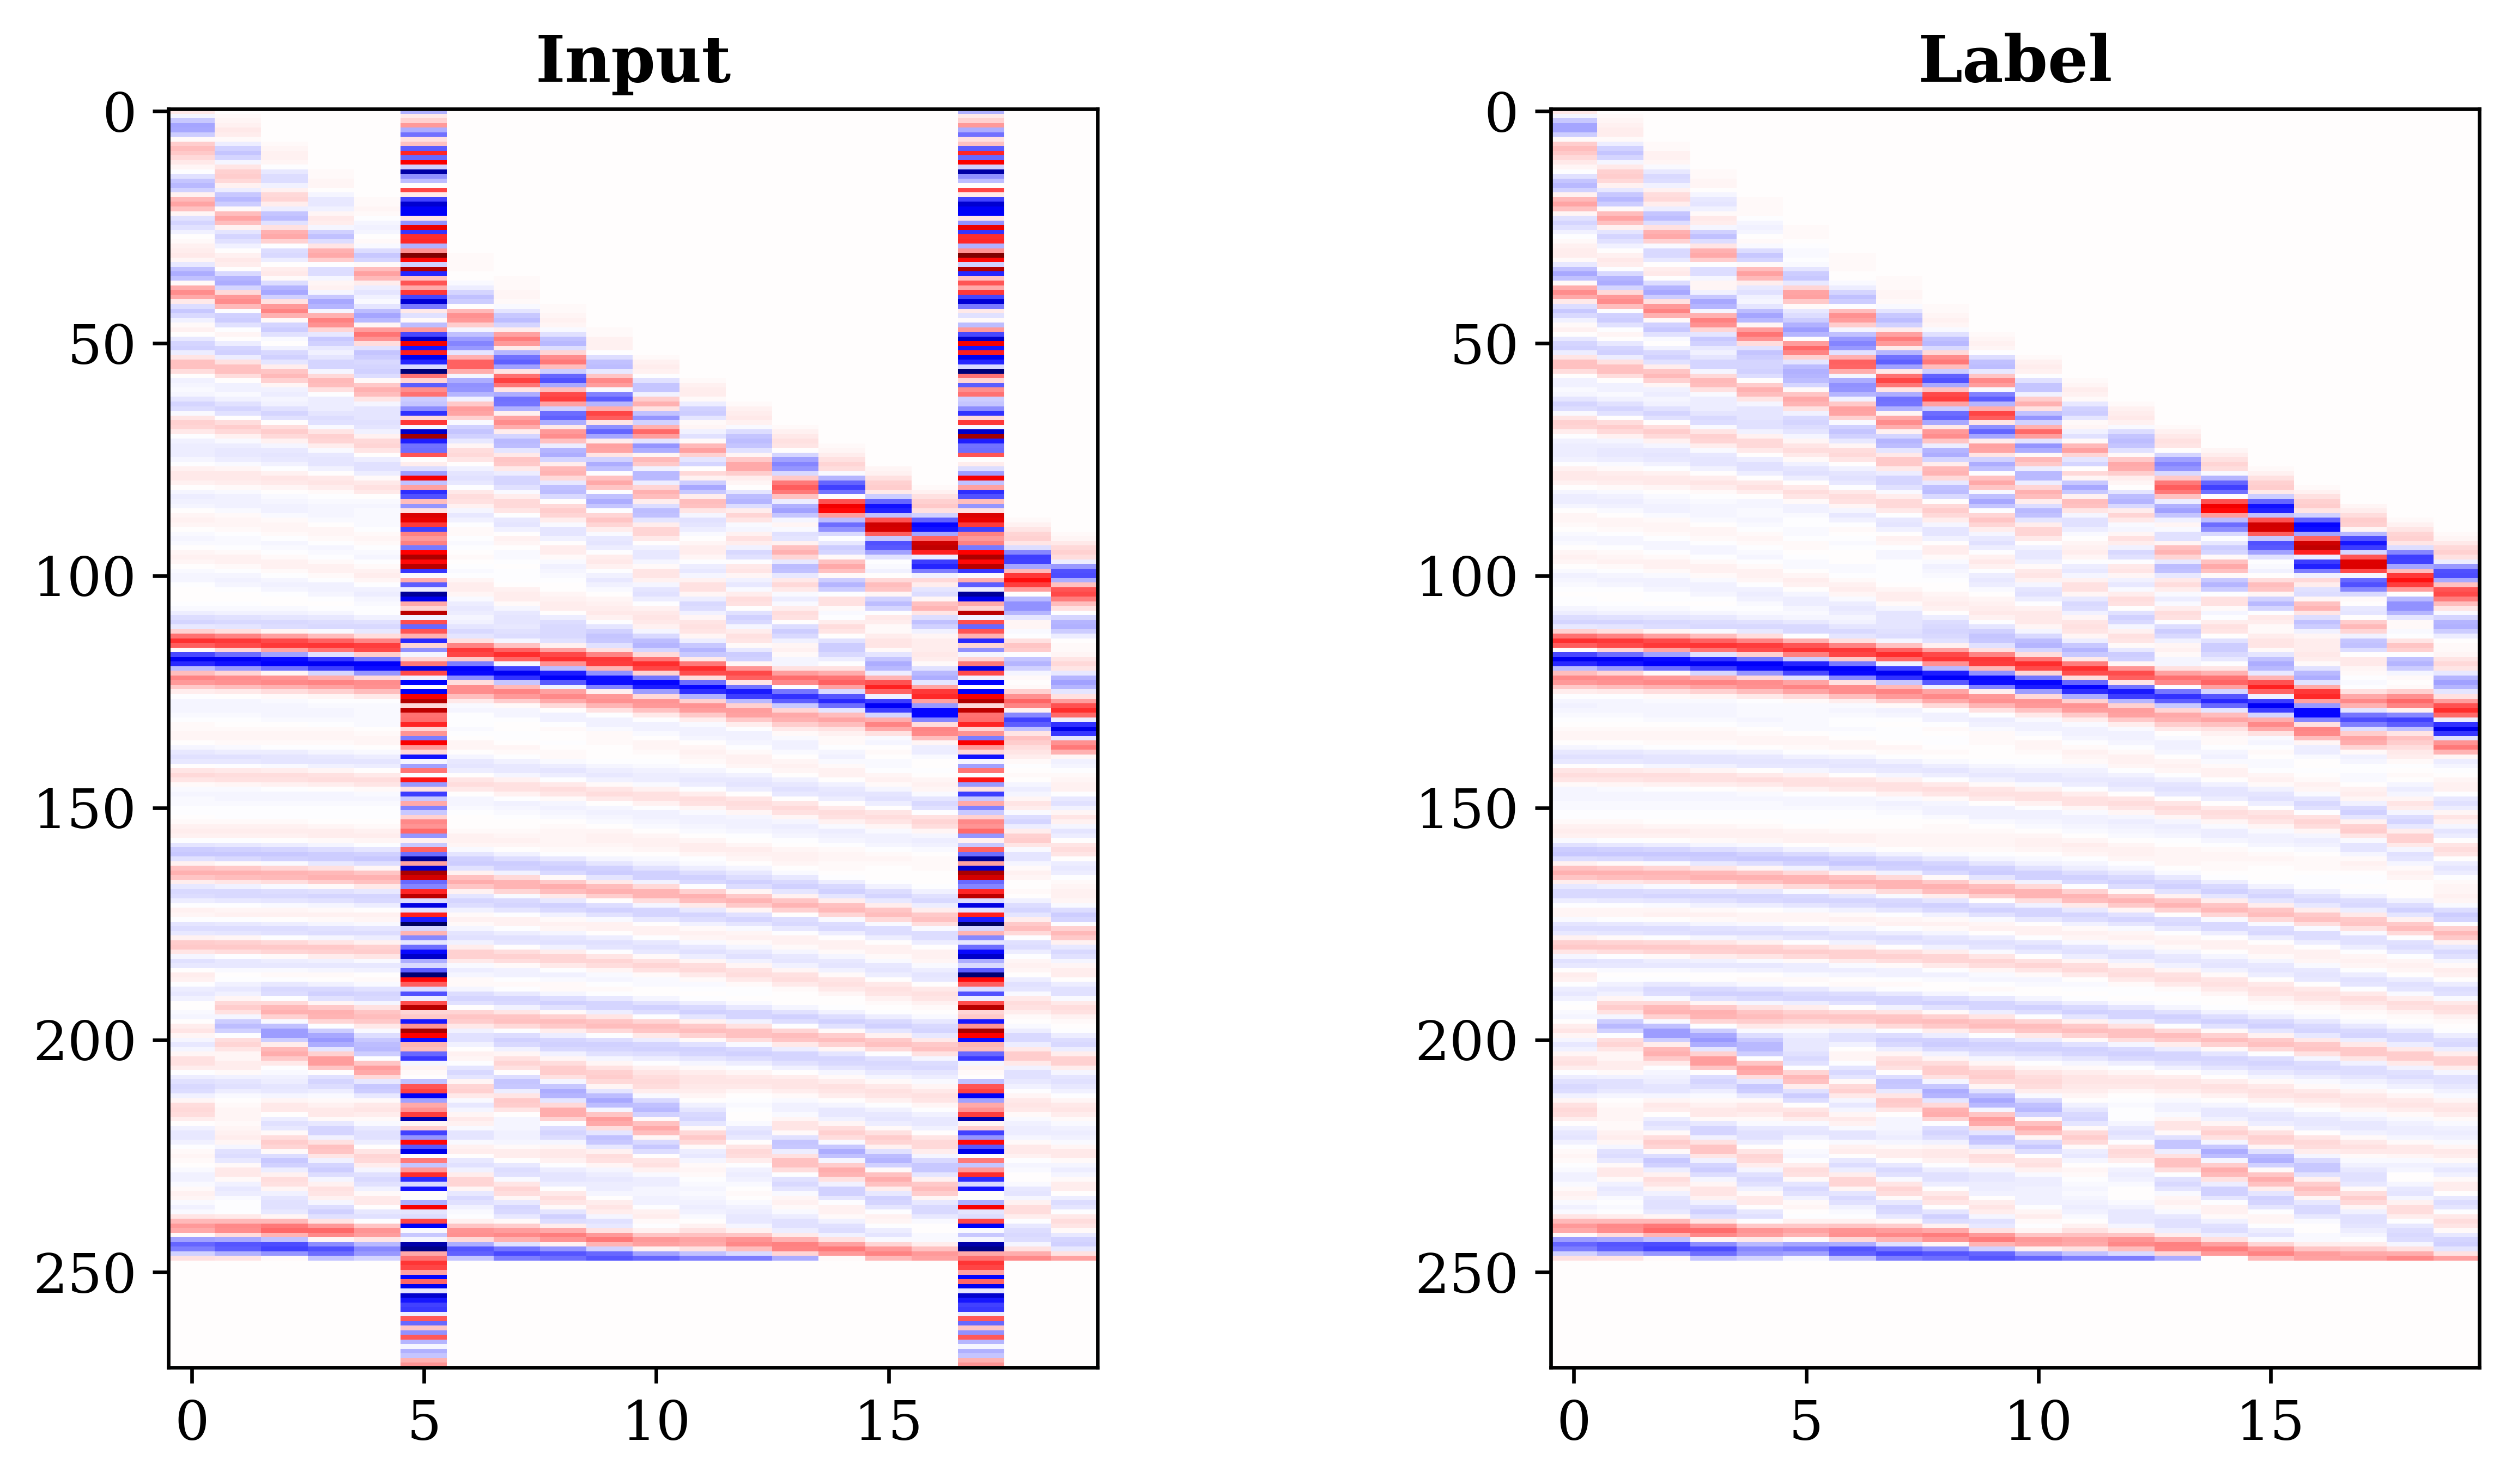

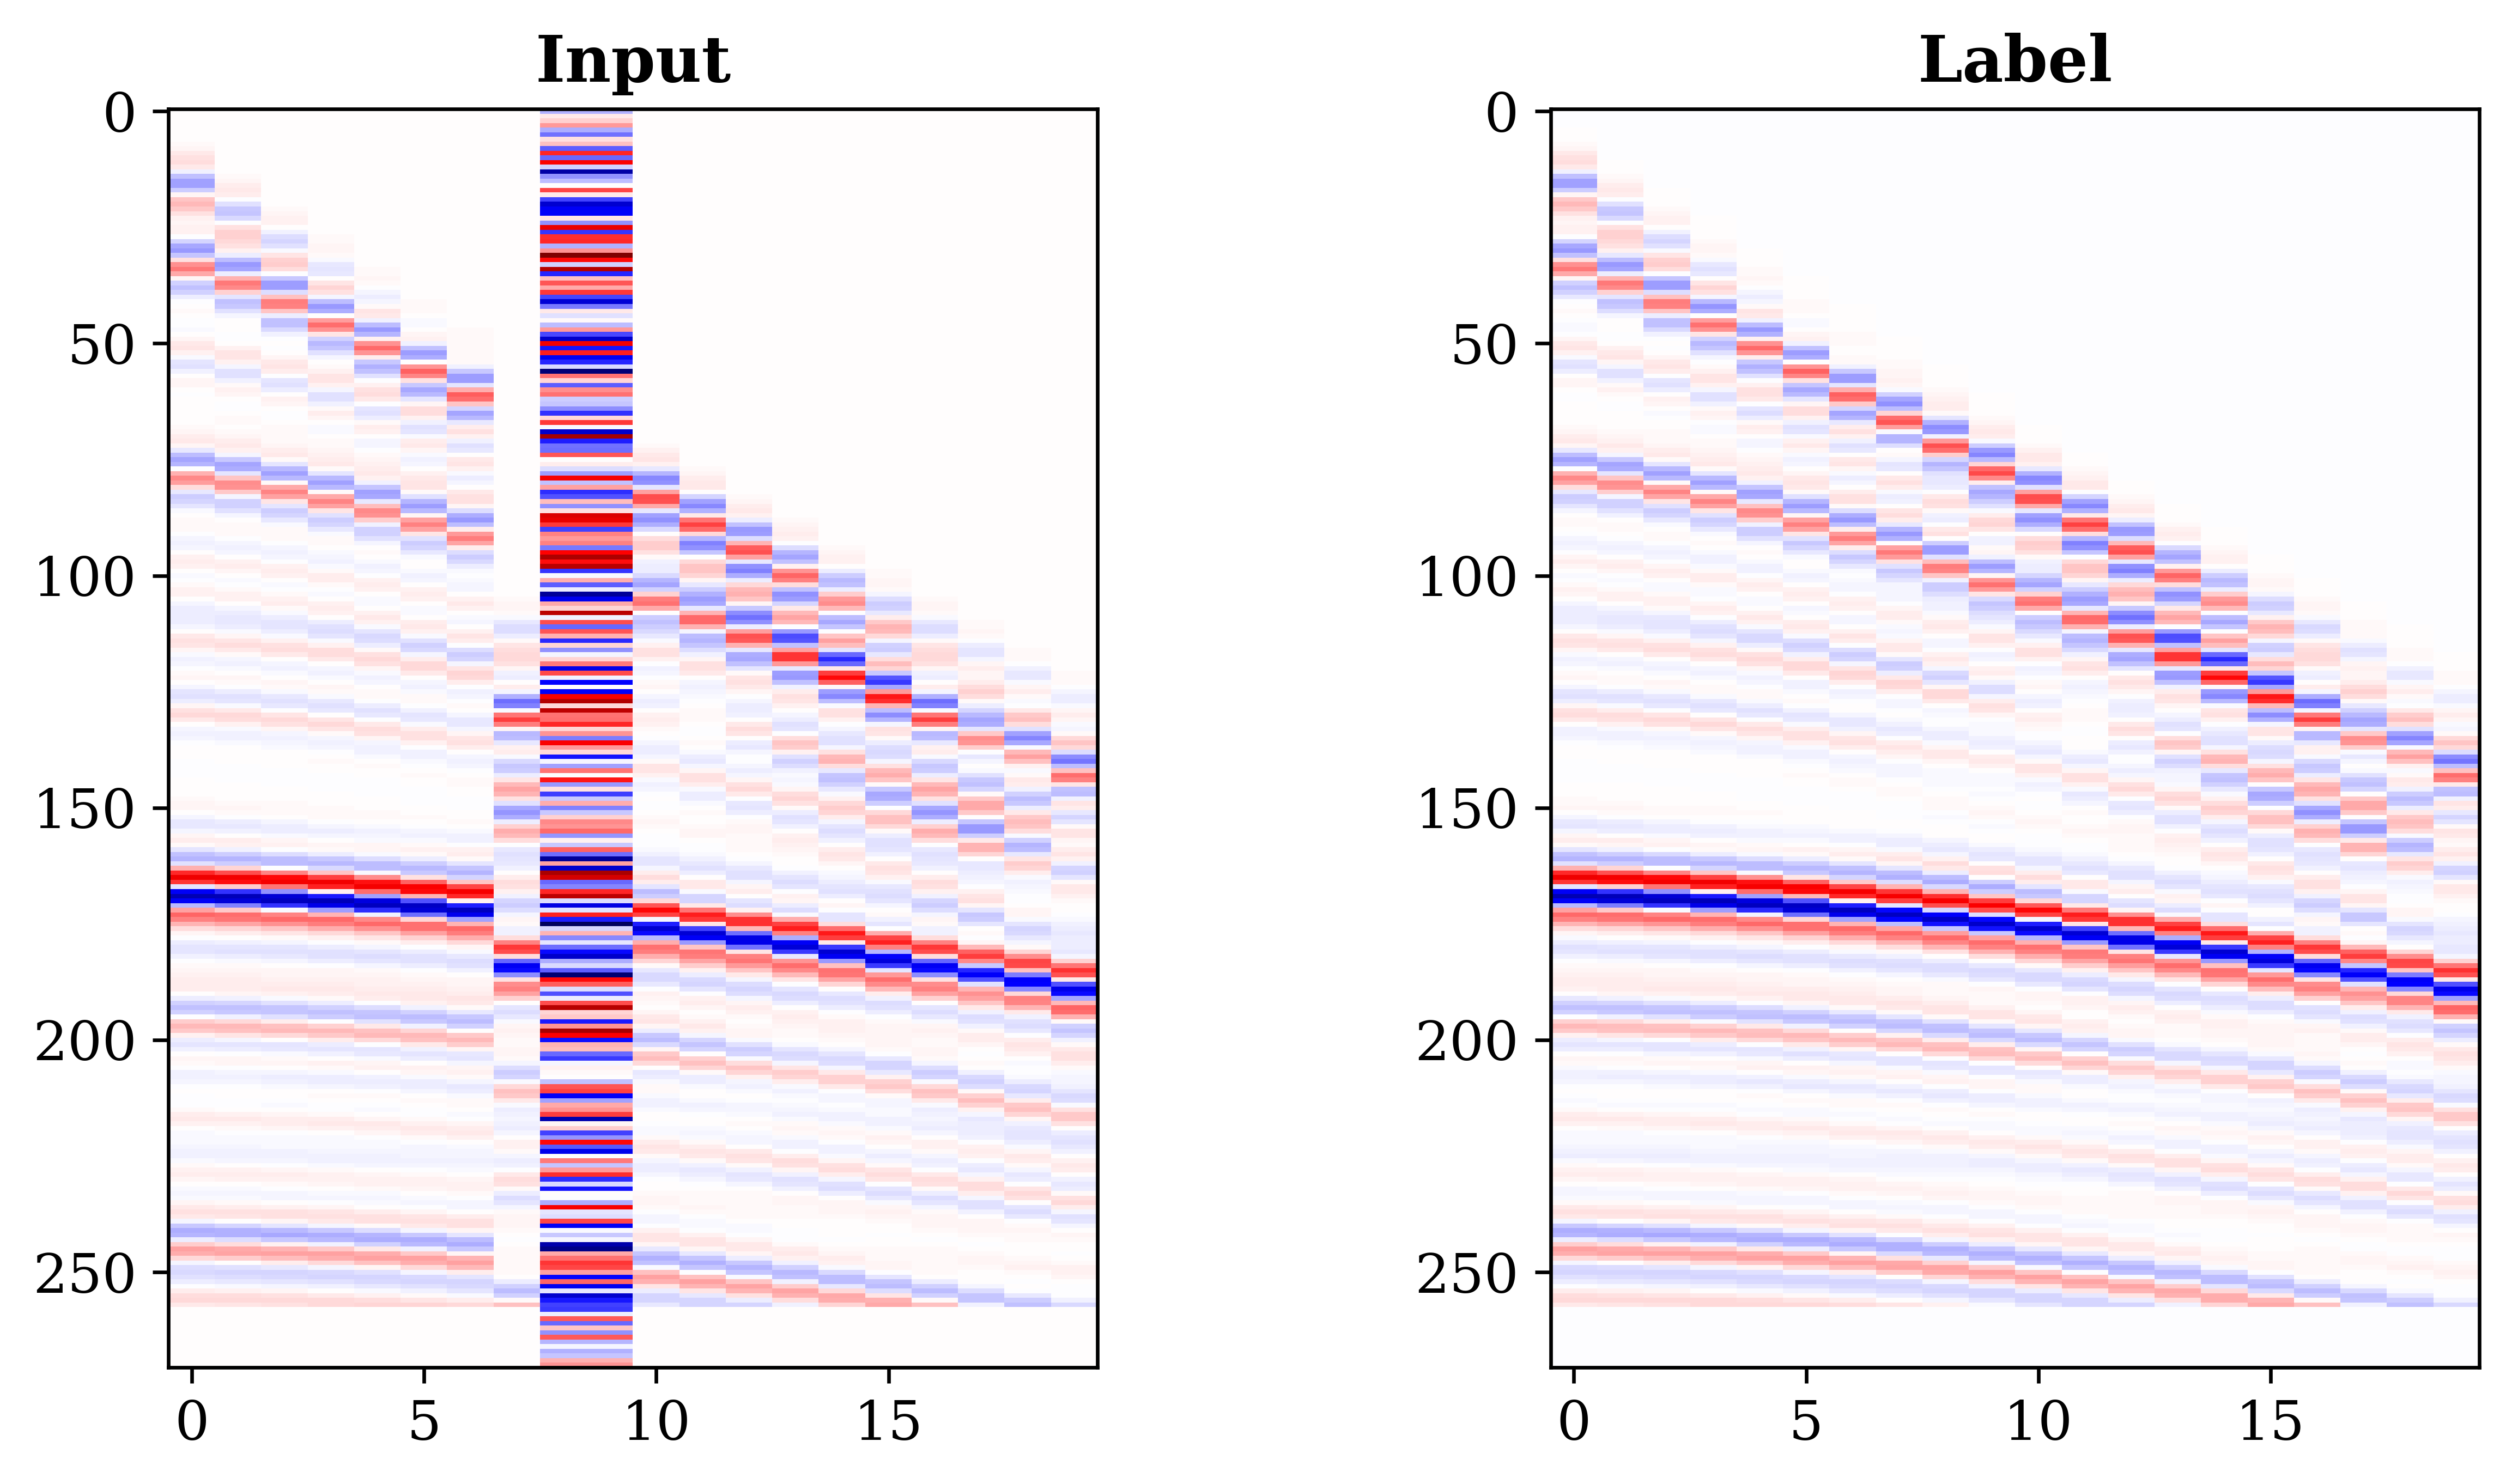

In [11]:
# Training data

idx =  torch.randint(train_data.encodings['inputs_embeds'].shape[0], (4,))

for inputs_embeds, labels in zip(train_data.encodings['inputs_embeds'][idx], 
                                 train_data.encodings['labels'][idx]):
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(inputs_embeds.swapaxes(0, 1) - inputs_embeds.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[0].set_title("Input")
    ax[1].imshow(labels.swapaxes(0, 1) - labels.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[1].set_title("Label")

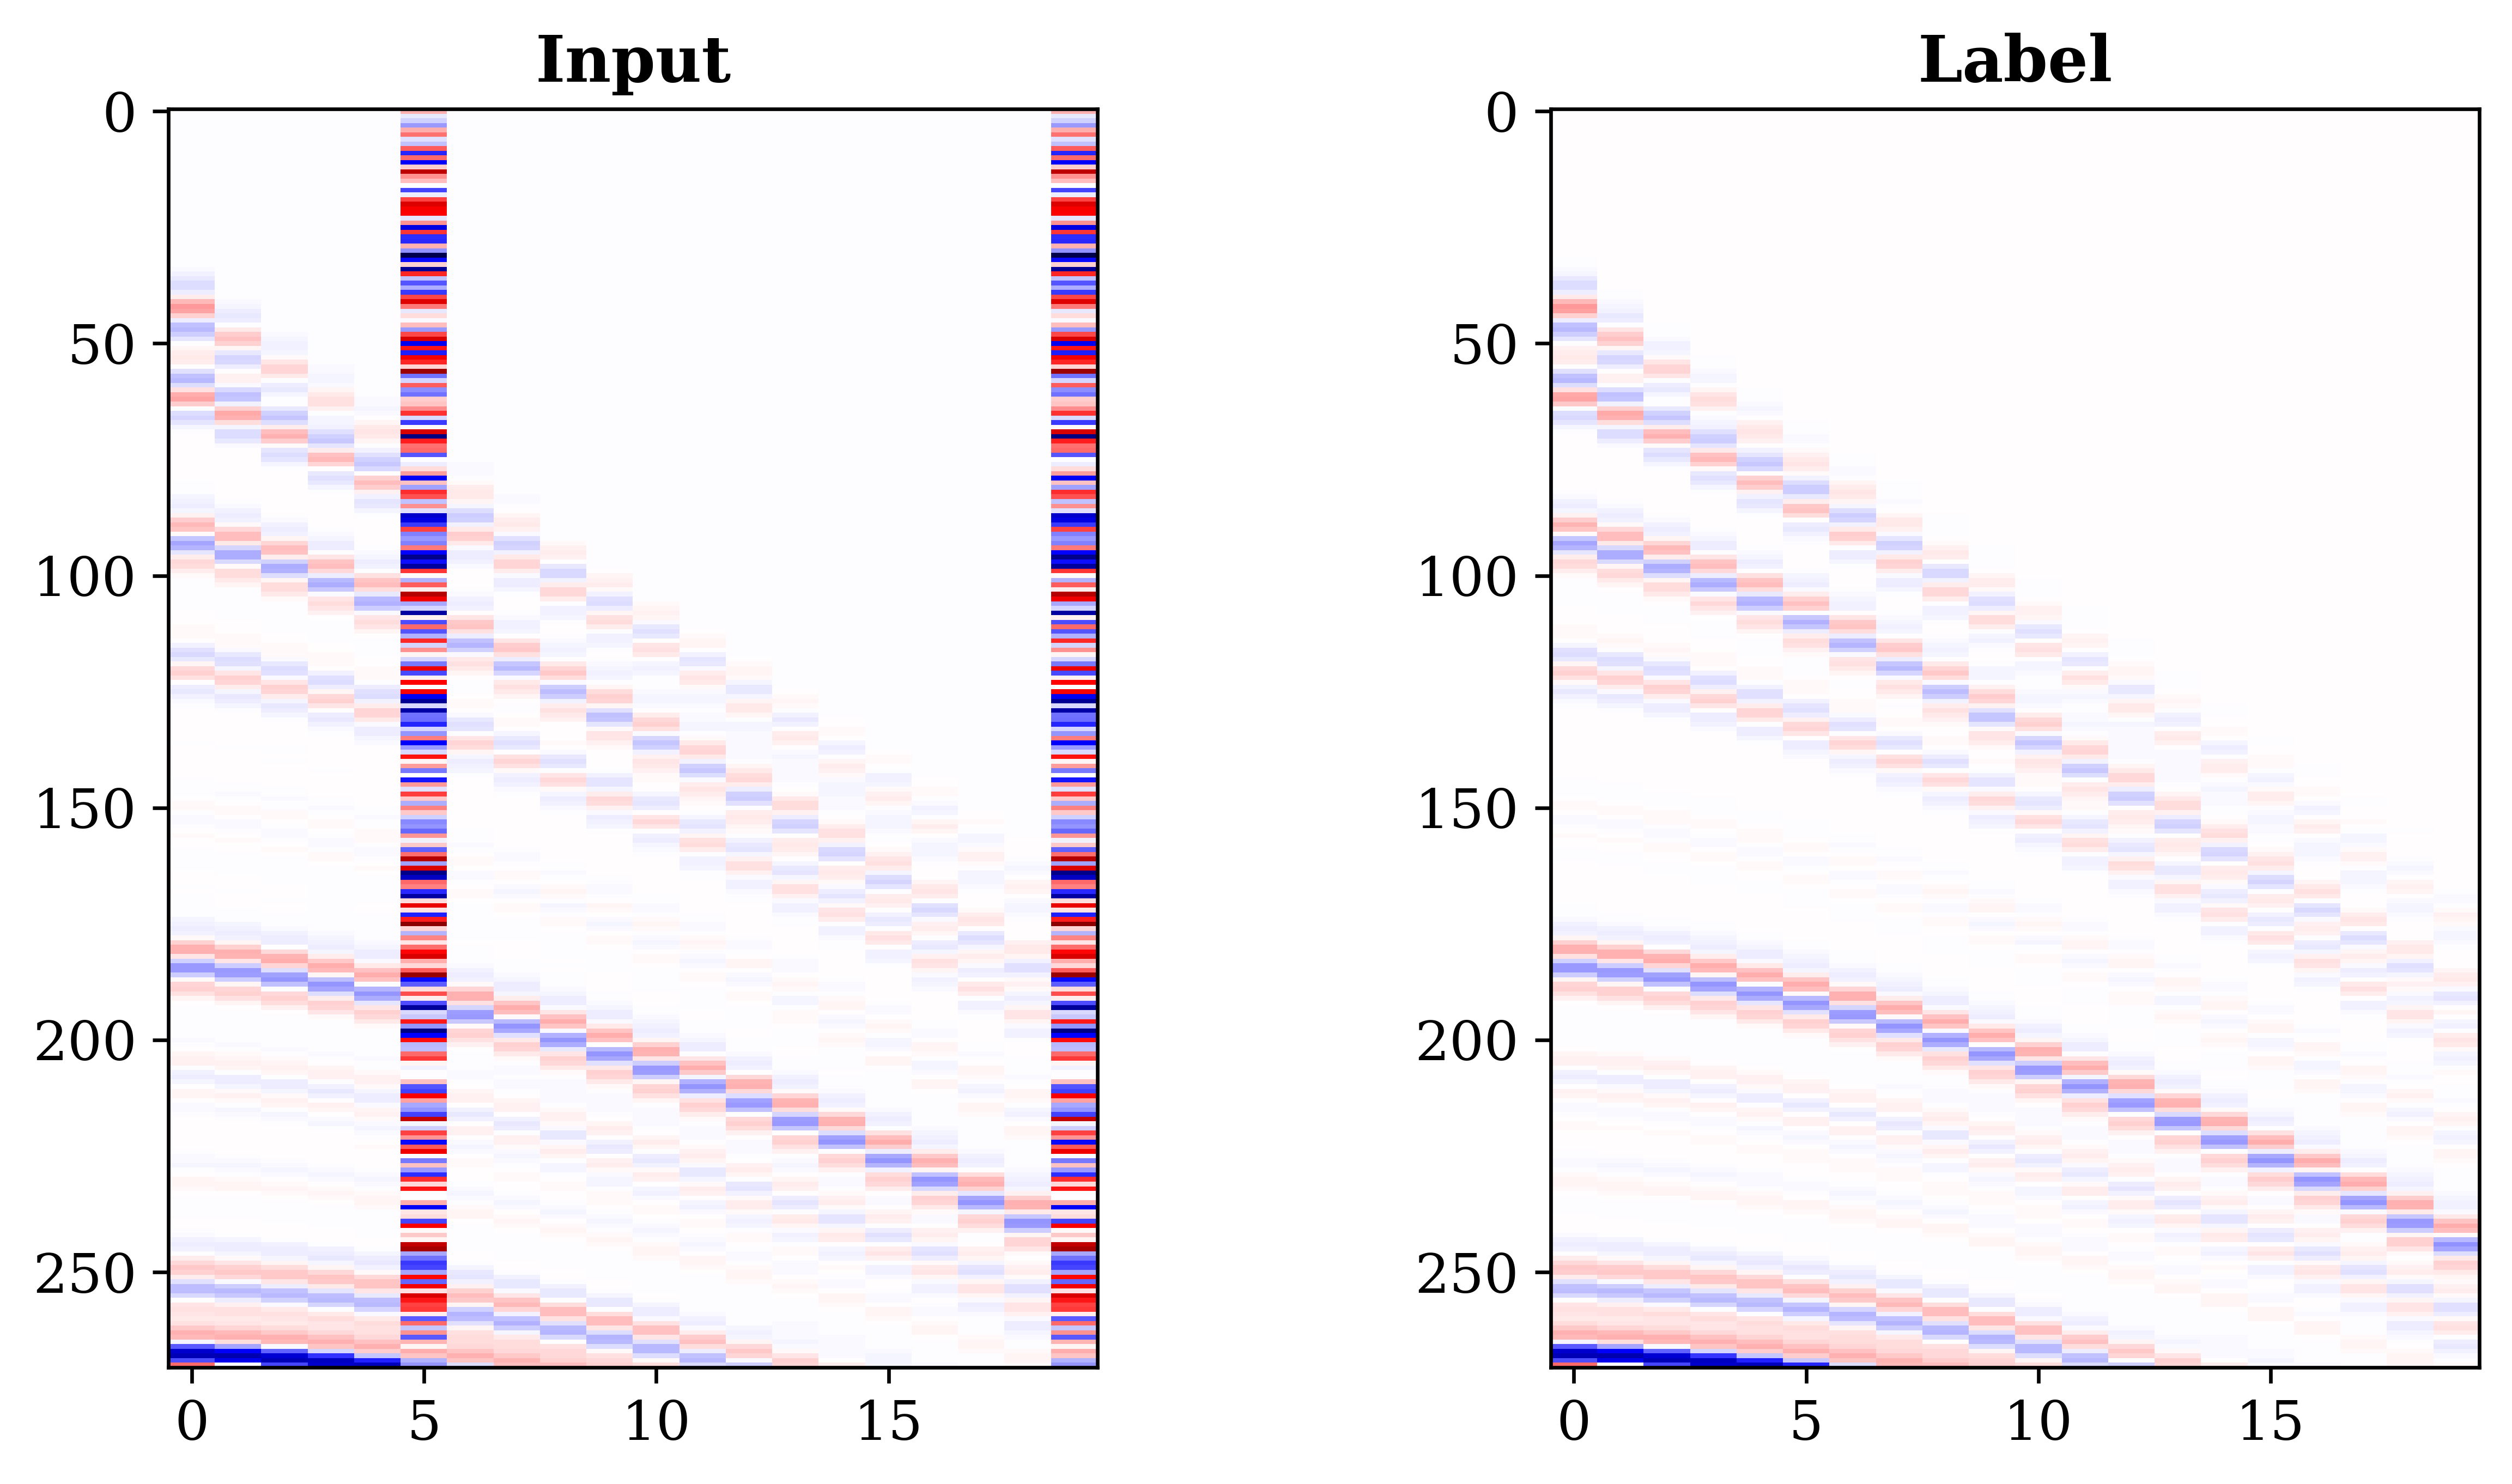

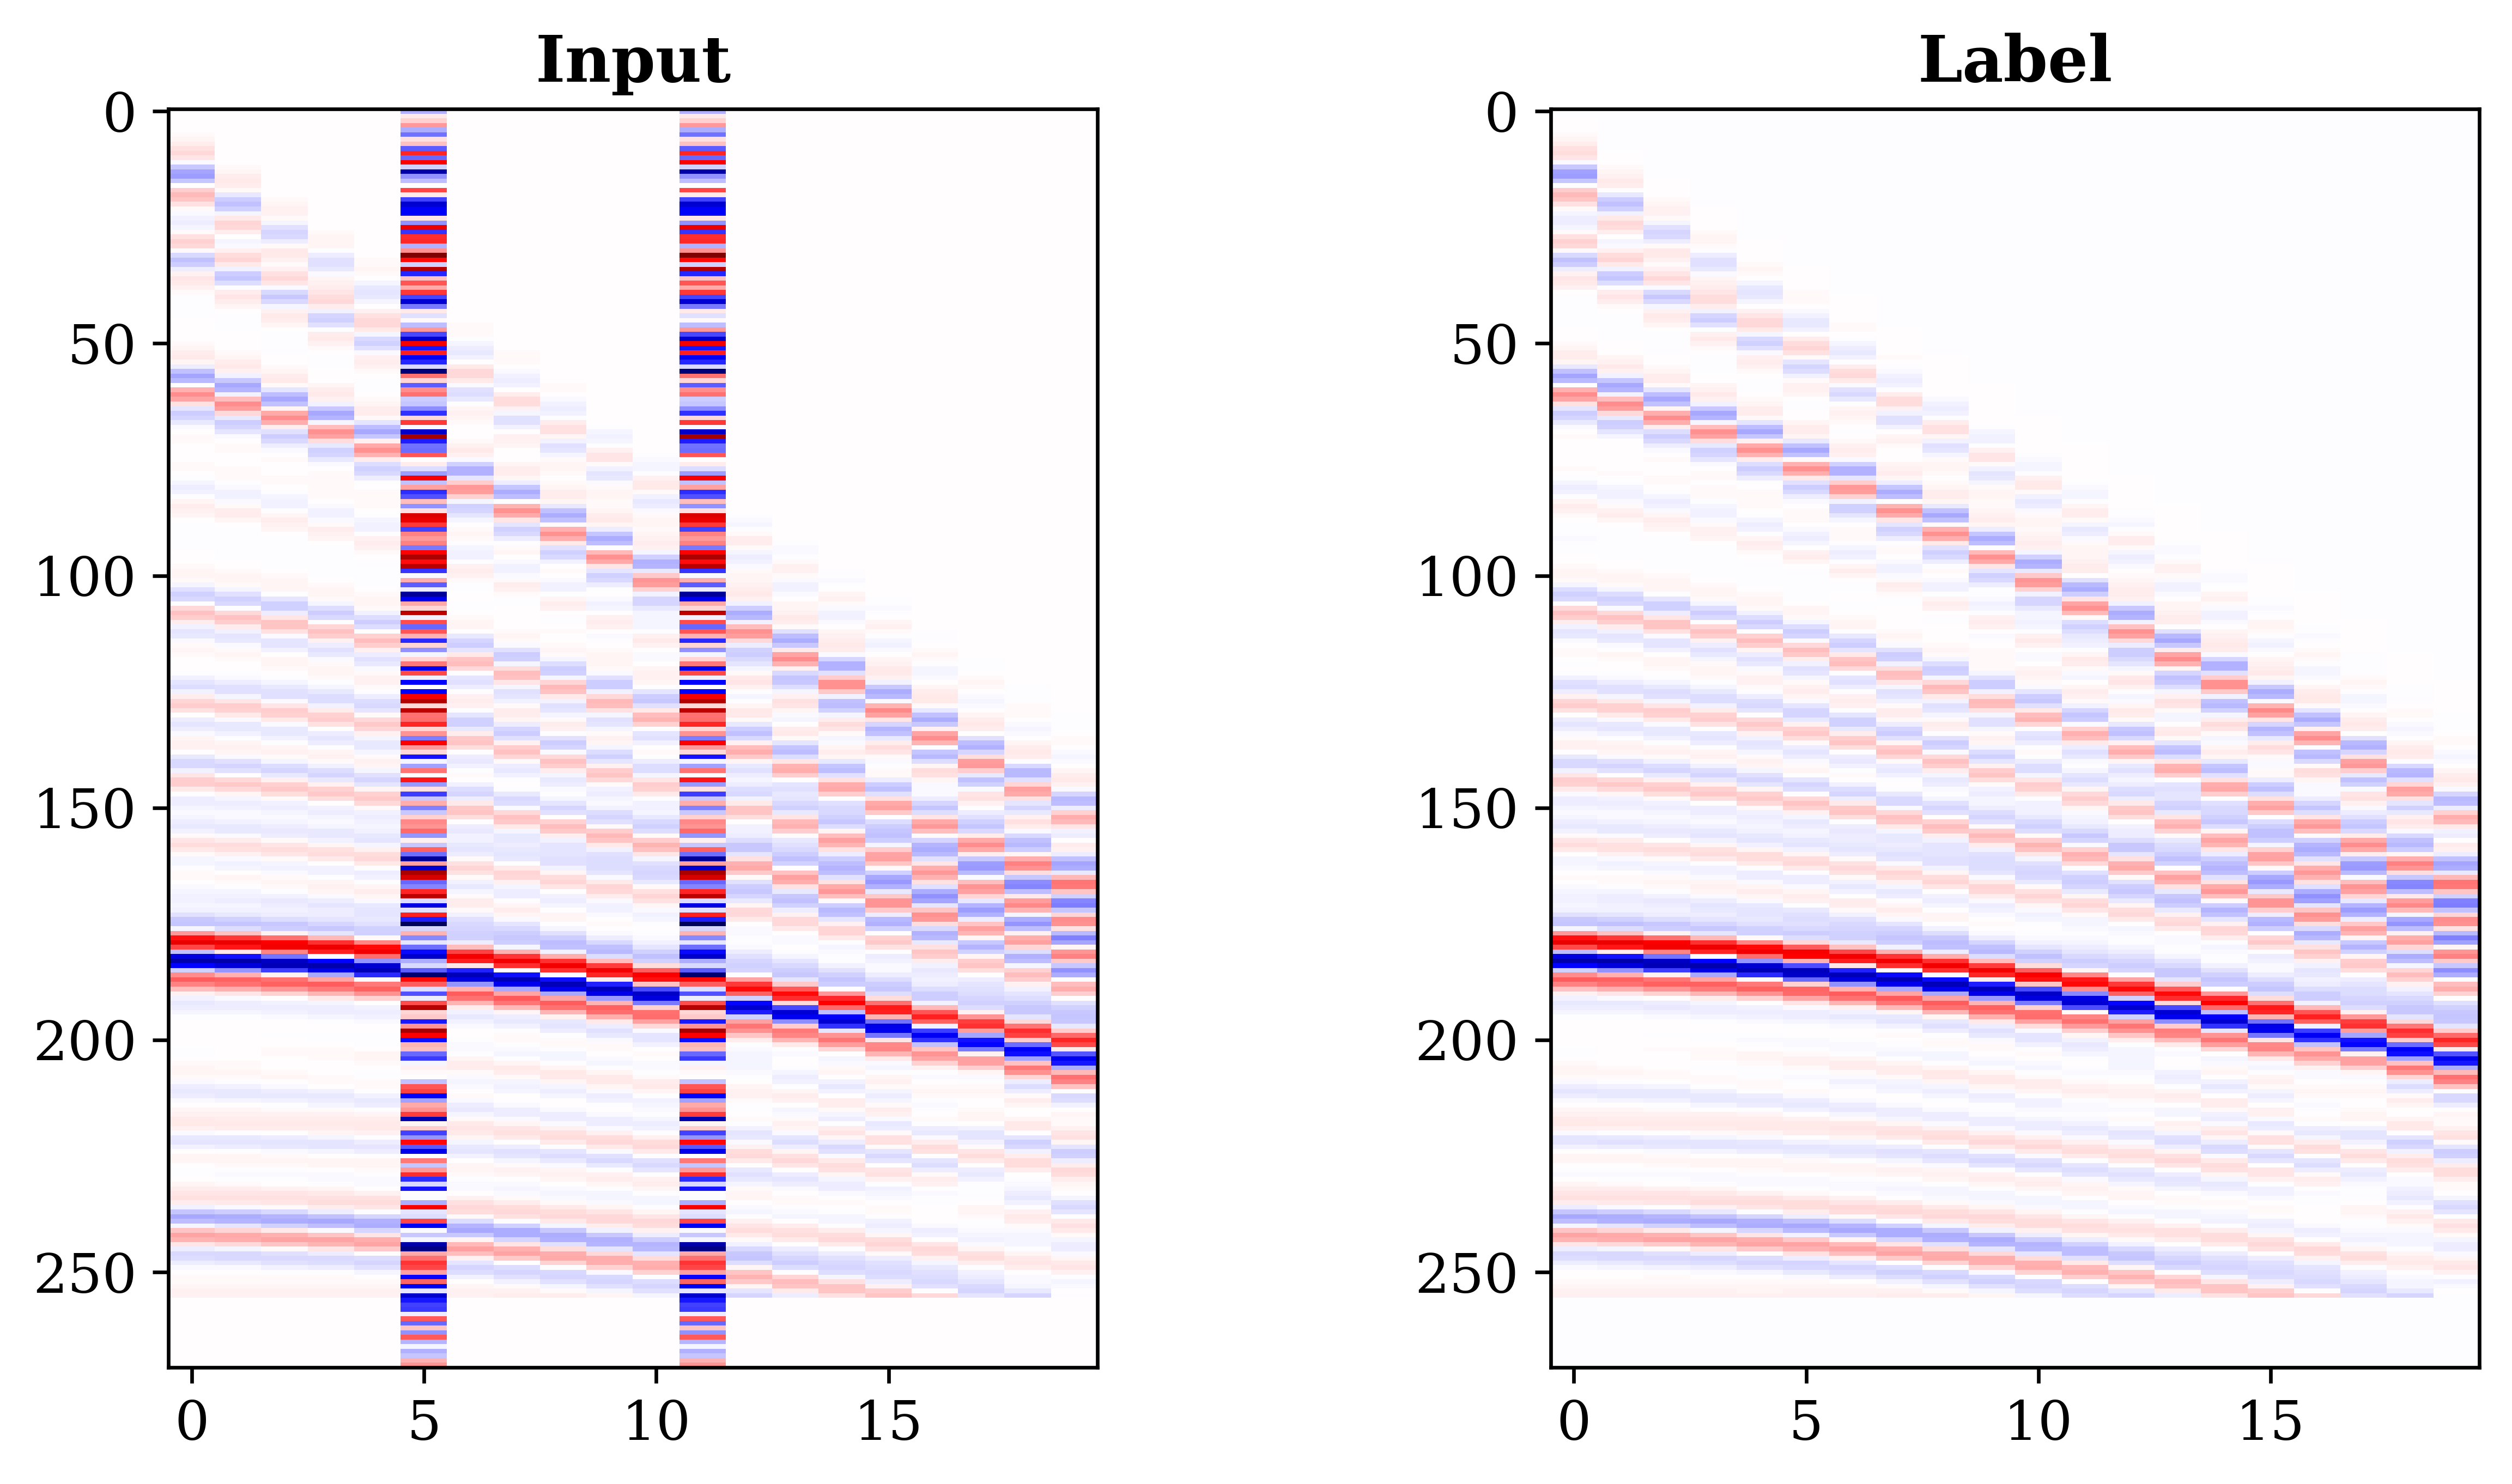

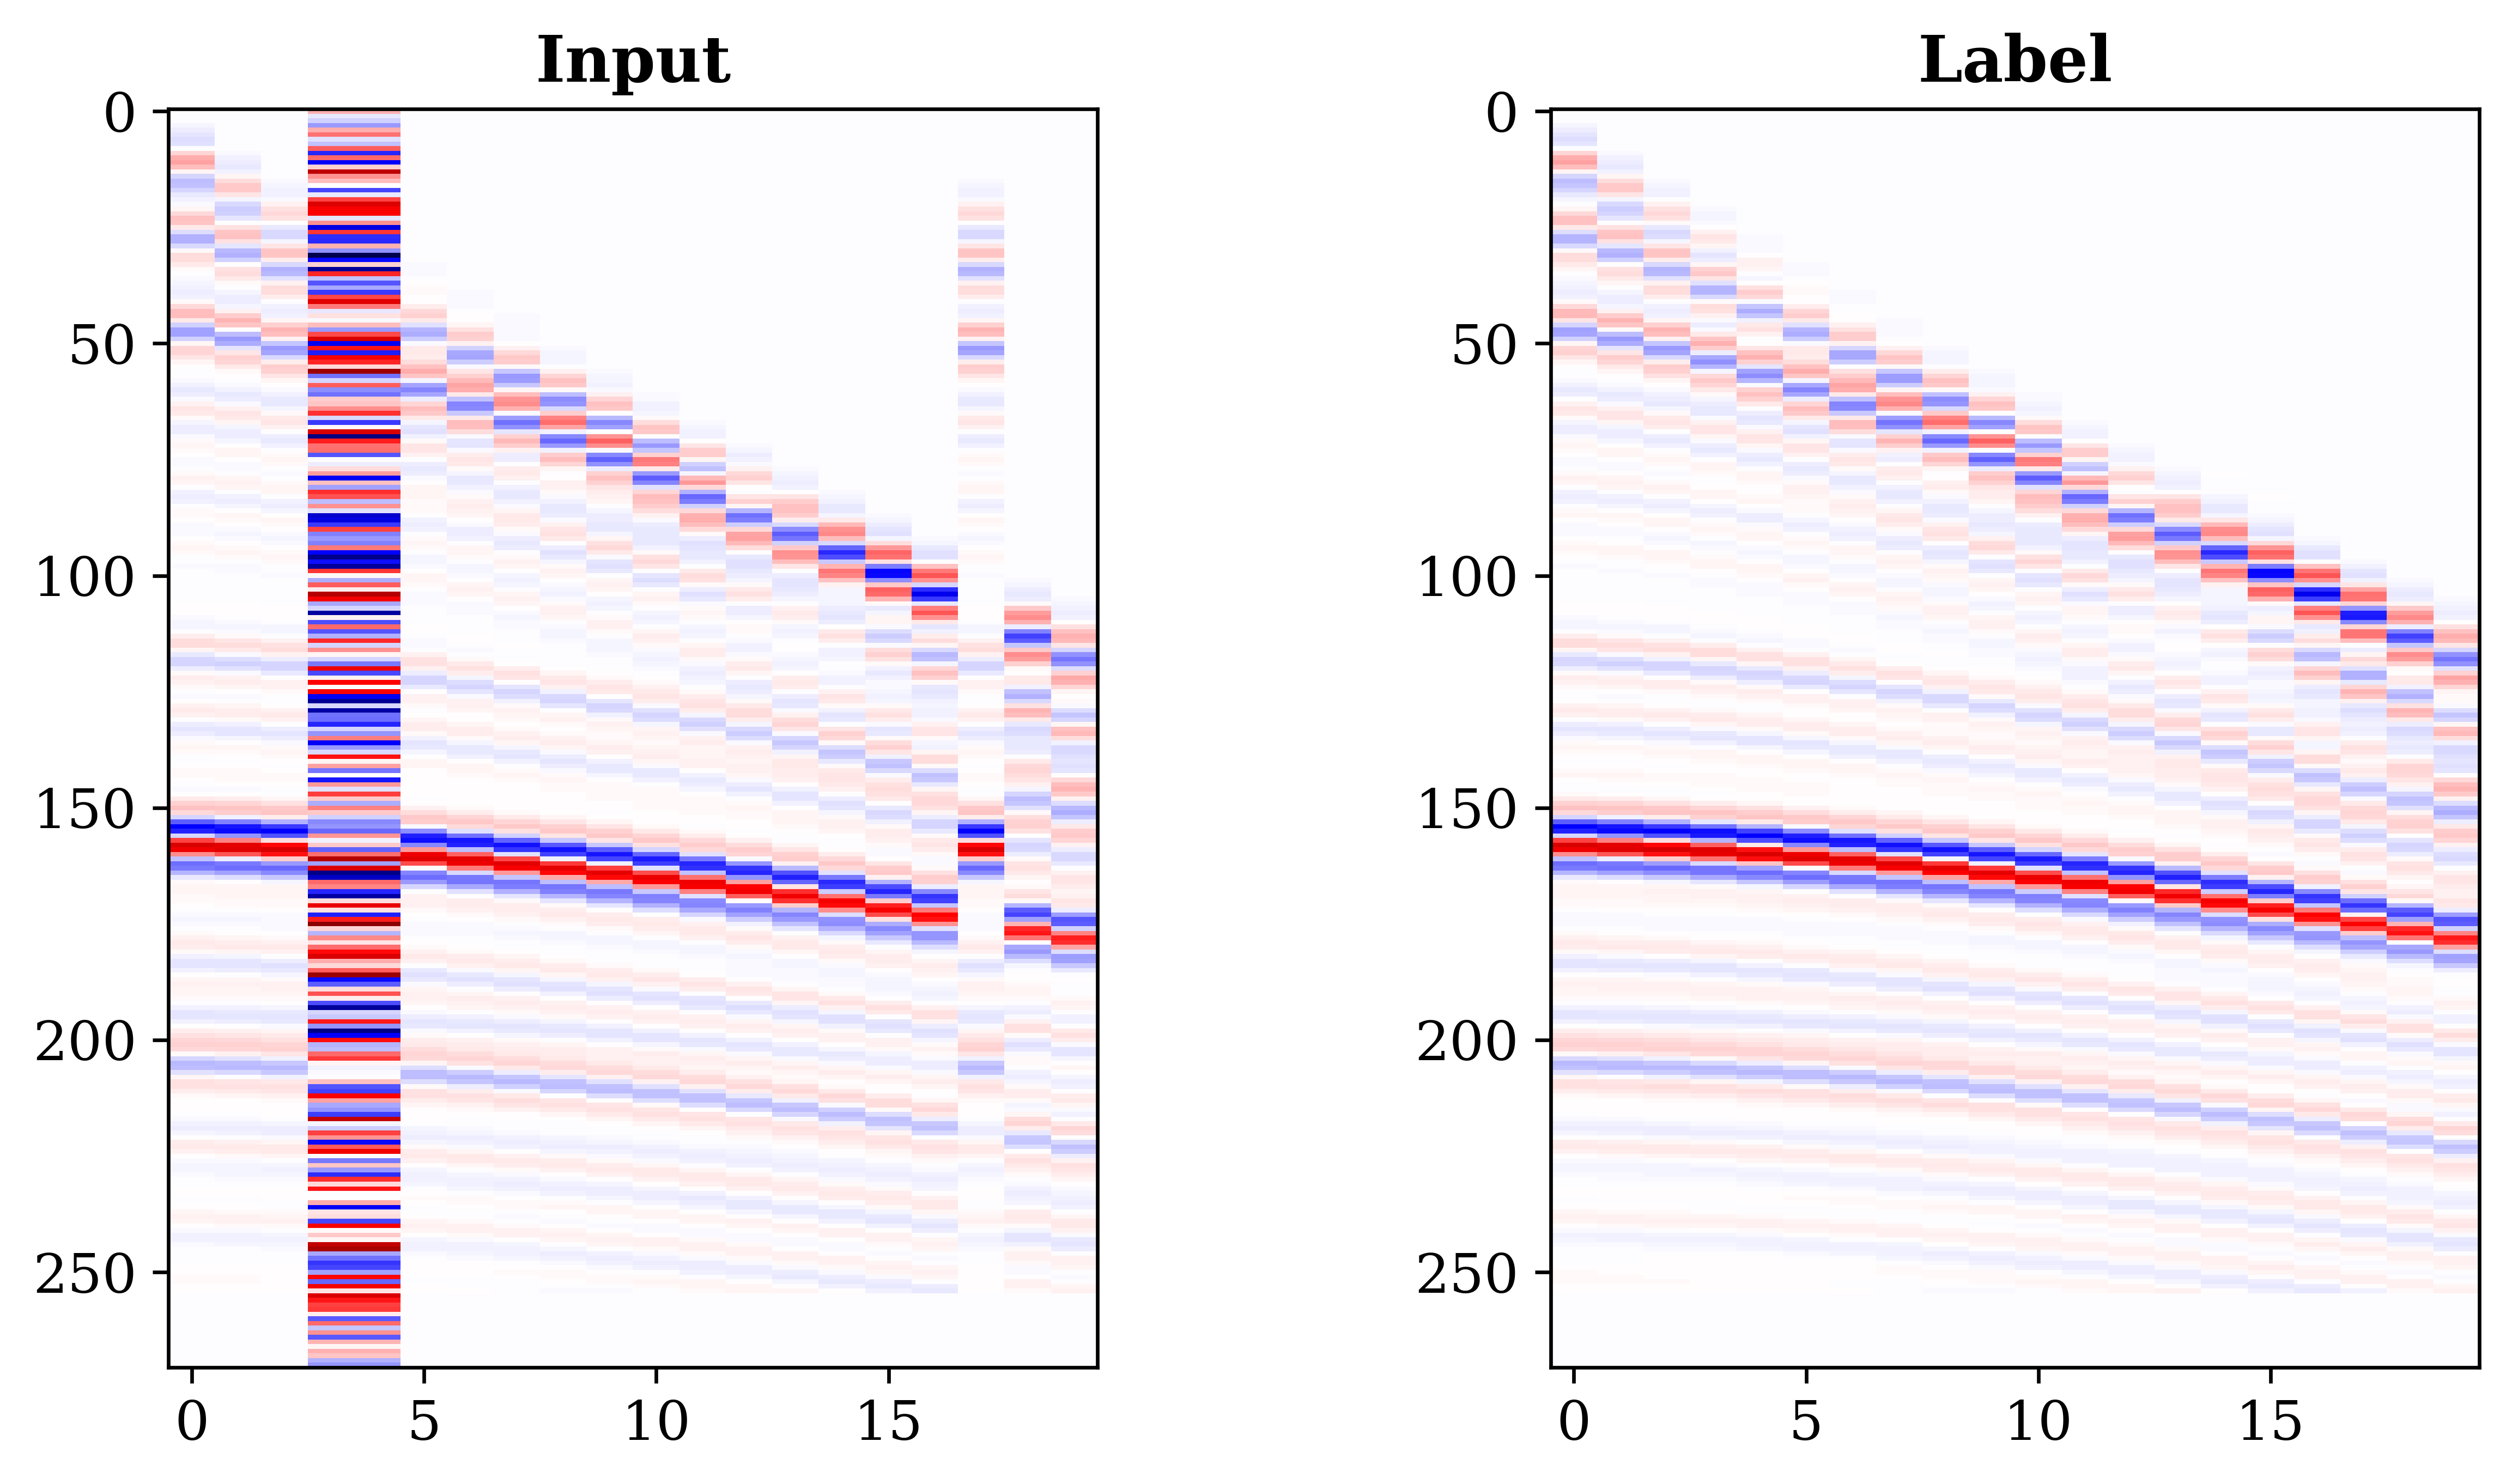

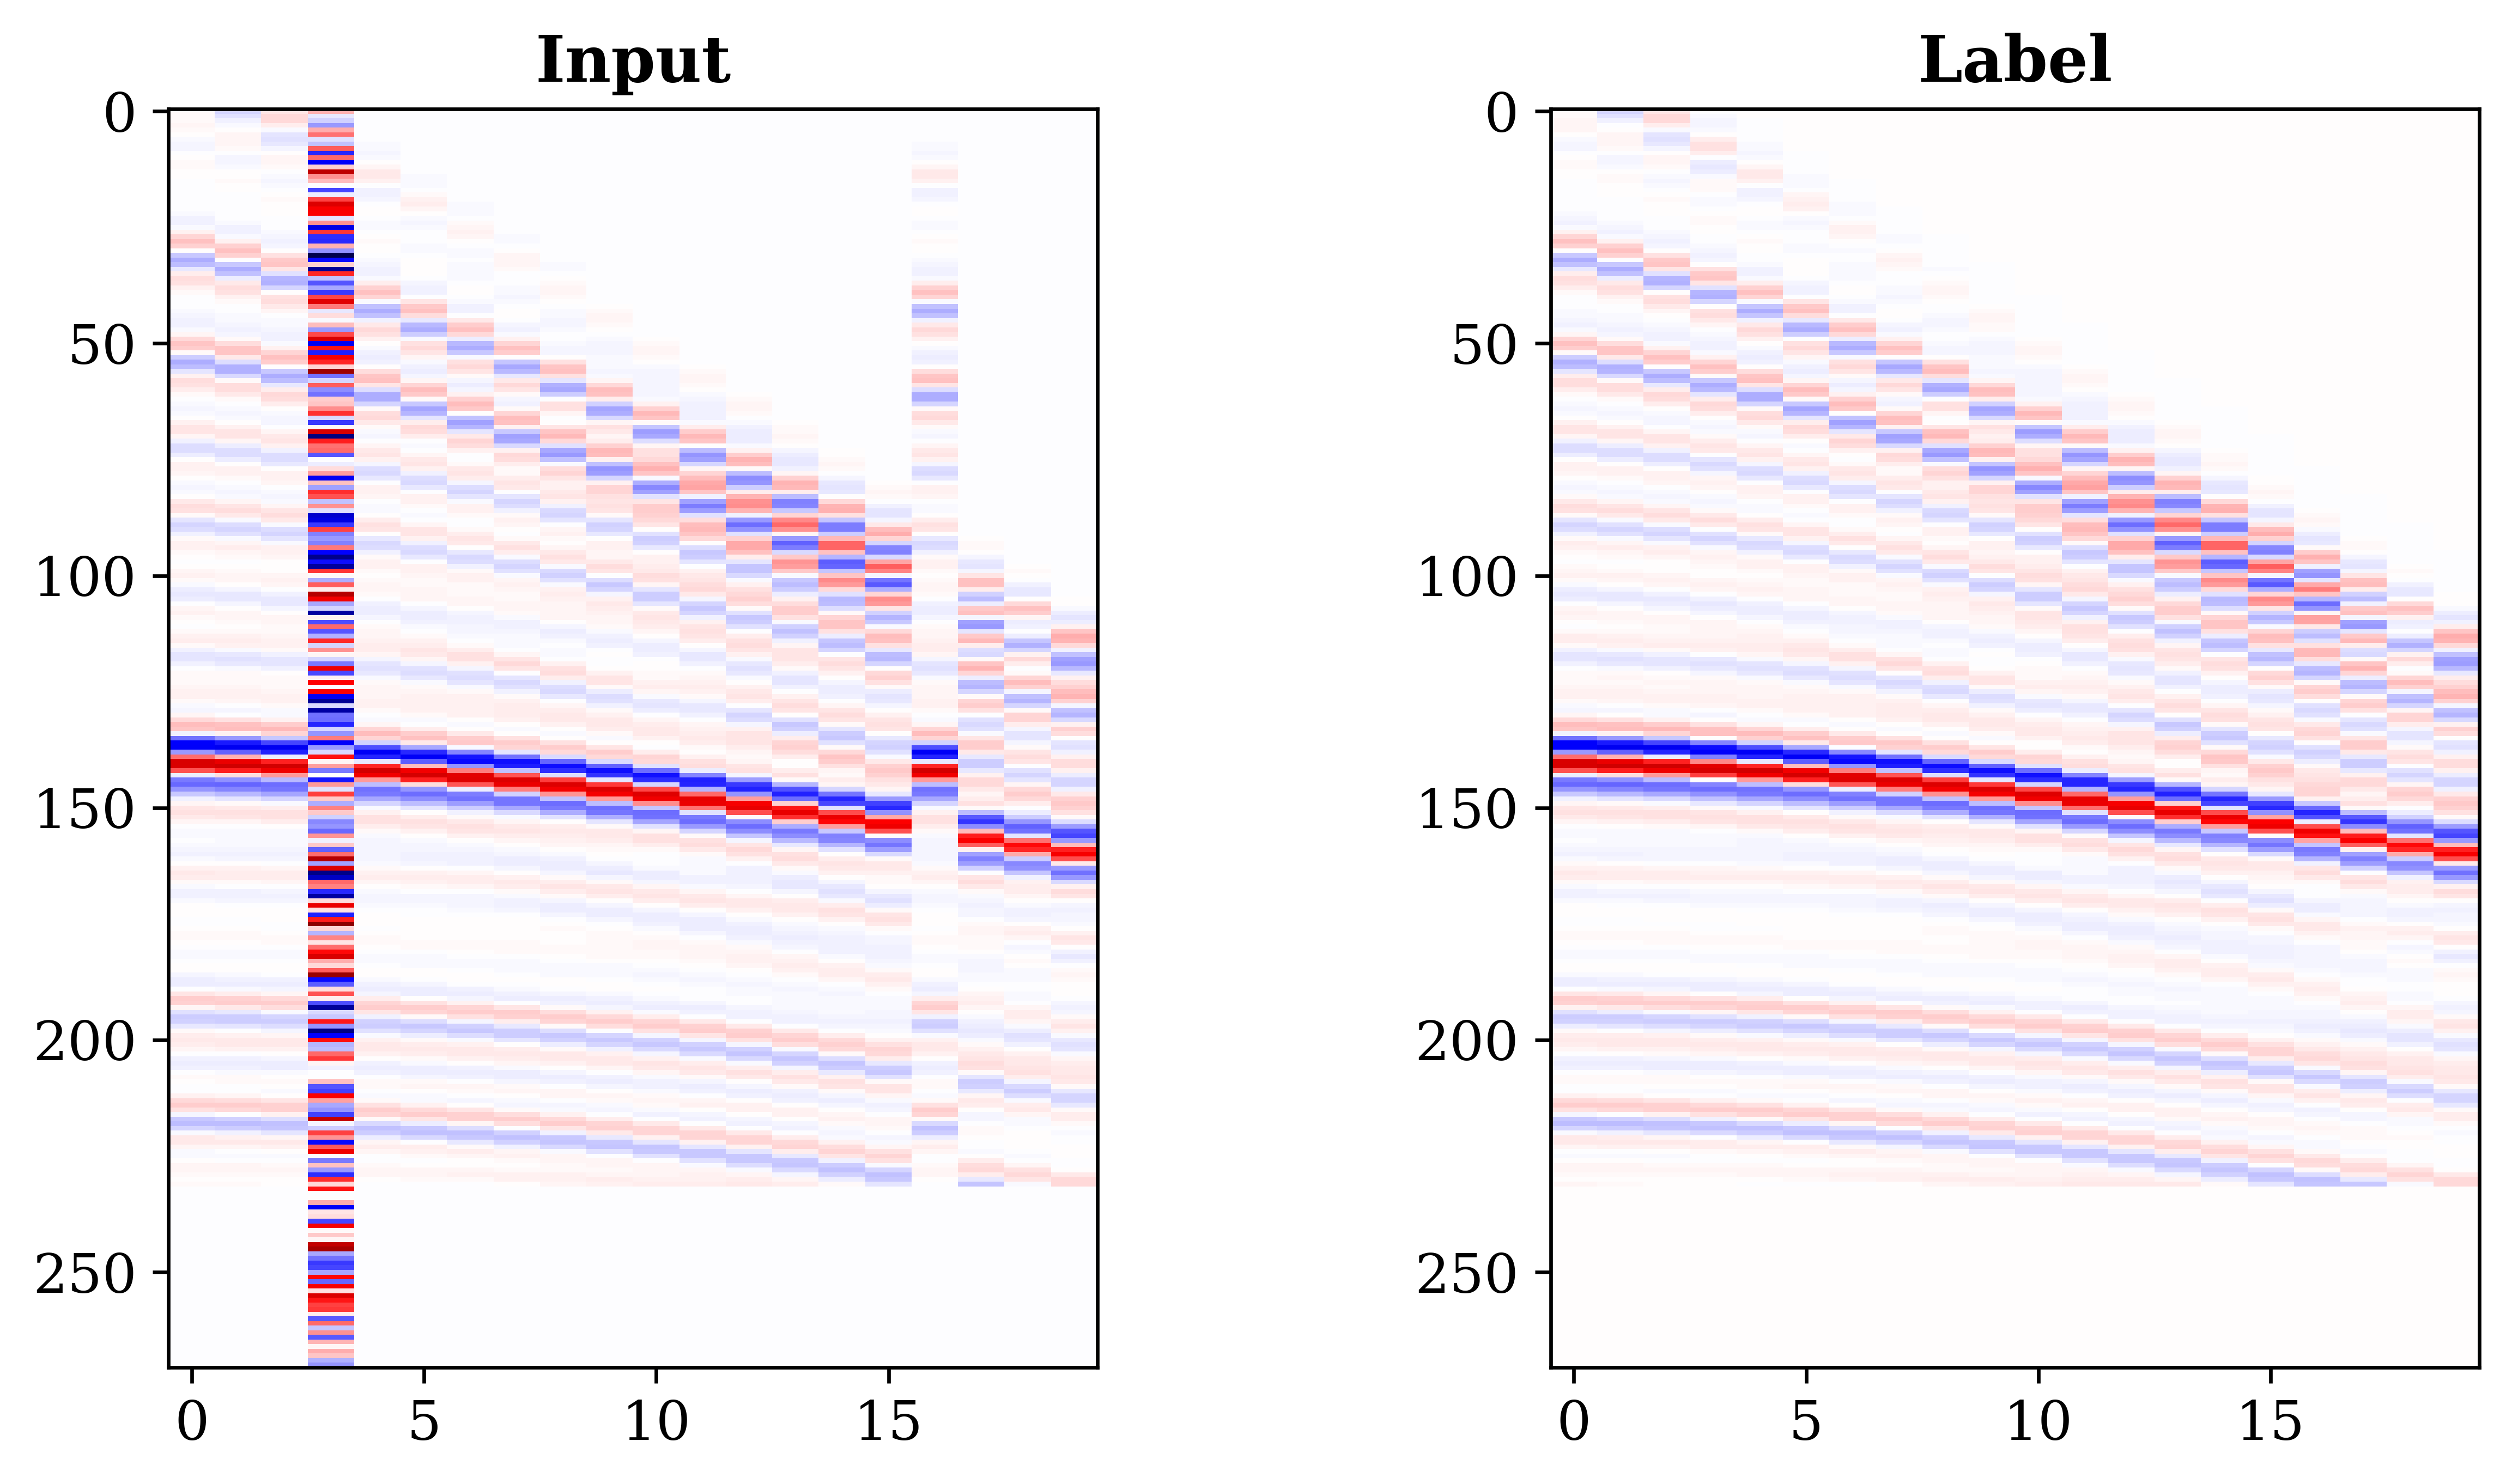

In [12]:
# Testing data

idx = torch.randint(test_data.encodings['inputs_embeds'].shape[0], (4,))

for inputs_embeds, labels, mask in zip(test_data.encodings['inputs_embeds'][idx], 
                                 test_data.encodings['labels'][idx],
                                test_data.encodings['mask_label'][idx]):
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(inputs_embeds.swapaxes(0, 1) - inputs_embeds.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[0].set_title("Input")
    ax[1].imshow(labels.swapaxes(0, 1) - labels.mean(), 
                 aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic', interpolation='none')
    ax[1].set_title("Label")

### Re-check dimension

We applied 10 (masking) x 3 (time shift) x 2 (polarity reversal) times of augmentation to each sample. Therefore, the total number of each of training and testing dataset must have been expanded 60 times than the original.

In [13]:
print("Training data shape: ", train_data.encodings['inputs_embeds'].shape)
print("Testing data shape: ", test_data.encodings['inputs_embeds'].shape)

Training data shape:  torch.Size([36000, 20, 271])
Testing data shape:  torch.Size([9000, 20, 271])


### Save dataset

In [14]:
!pwd

/home/masa/storseismic


In [15]:
parent_dir = "./data/pretrain"

if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)
    torch.save(train_data, os.path.join(parent_dir, "train_data.pt"))
    torch.save(test_data, os.path.join(parent_dir, "test_data.pt"))
    print("Saved successfully")
elif os.path.exists(parent_dir):
    check = input("Directory exist, overwrite? (y/n)")
    if check == 'y':
        torch.save(train_data, os.path.join(parent_dir, "train_data.pt"))
        torch.save(test_data, os.path.join(parent_dir, "test_data.pt"))
        print("Saved successfully")
    else:
        print("Saving failed")
else:
    print("Saving failed")

Saved successfully


## References

Devlin, J., M.-W. Chang, K. Lee, and K. Toutanova, 2018, Bert: Pre-training of deep bidirectional transformers for language understanding: arXiv preprint arXiv:1810.04805.

Harsuko, R., and T. Alkhalifah, 2022, Storseismic: An approach to pre-train a neural network to store seismic data features: 83rd EAGE Annual Conference & Exhibition, European Association of Geoscientists & Engineers, 1–5.